In [2]:
import numpy as np

from ipywidgets import interact
from matplotlib import pyplot as plt
from scipy import special, stats

%matplotlib inline

# Bayesian Inference

For two random variables $ \textbf{x} $ and $ \textbf{y} $, Bayes' rule says
$$ p(\textbf{y} \vert \textbf{x}) = \frac{p(\textbf{x} \vert \textbf{y}) p(\textbf{y})}{p(\textbf{x})} \propto p(\textbf{x} \vert \textbf{y}) p(\textbf{y}). $$

- $ p(\textbf{y} \vert \textbf{x}) $ is the **posterior** distribution over $ \textbf{y} $ given $ \textbf{x} $; it characterizes our new beliefs about $ \textbf{y} $ after we've observed $ \textbf{x} $.
- $ p(\textbf{x} \vert \textbf{y}) $ is the conditional distribution over $ \textbf{x} $ given $ \textbf{y} $, or alternatively, the **likelihood** of $ \textbf{y} $ given data $ \textbf{x} $. The likelihood is a function of $ \textbf{y} $, and from this point of view, **the likelihood function is not a probability distribution**. Go back and read this point again.
- $ p(\textbf{y}) $ is the **prior** distribution over $ \textbf{y} $; it characterizes our beliefs about the random variable $ \textbf{y} $ before we've made any observations or gathered any data.
- $ p(\textbf{x}) = \int p(\textbf{x}, \textbf{y}) \ \mathrm{d} \textbf{y} = \int p(\textbf{x} \vert \textbf{y}) p(\textbf{y}) \ \mathrm{d} \textbf{y} $ is the **evidence** or **marginal likelihood** of the data, or the average value of the likelihood under the prior; it characterizes the probability of seeing data $ \textbf{x} $ when we use a particular likelihood and prior i.e. when we use a particular model for the data. For this reason, the marginal likelihood is often used for model comparison.

Bayesian inference refers to the broad challenge of computing the posterior distribution for an arbitrary likelihood function and prior distribution. Generally, the product of the likelihood and prior gives rise to a complex, intractable distribution which is difficult to reason about and work with.

## Conjugate priors
The idea of conjugacy in Bayesian inference is an appealing one. We say a particular prior is conjugate to some likelihood if the resulting posterior distribution is in the same family as the prior. Recalling that the posterior is generally a complex, unwieldy distribution for an arbitrary choice of likelihood and prior, conjugacy is indeed a very desirable property, since we can compute the posterior in closed form. 

## An example of a conjugate prior

As often happens in life, imagine someone comes up to you and asks whether the coin they're holding is fair. Your accoster, a wise Bayesian, is not interested in a binary decision about its fairness, but wants you to quantify your beliefs over the entire range of its possible fairness. You are allowed to flip the coin as often as you like for the next few minutes.

For a moment, we consider just flipping the coin as fast as we can, keeping a running average of the number of heads, and returning that answer when we're out of time. However, if something goes wrong, and the stranger is particularly mischievous, we may only get a few flips before we're forced to stop, and our guess will be heavily influenced by the first few outcomes. Even a fair coin won't justify its fairness in a few flips! With this in mind, remembering the mysterious stranger has no interest in a point estimate, and knowing the value of being Bayesian when expressing our beliefs about events, we decide to tackle this problem with Bayes' rule. This means we need to decide on two things:

- What is our prior? 
- What is our likelihood function? 

#### The prior distribution
There's a natural way to quantify fairness here: our beliefs about the fairness of a coin lie on a continuous scale from 0 to 1. We also know that coins tend to be fair. We're a bit suspicious in this case though, because this isn't an arbitrary coin, it's a challenge from the mysterious stranger. So what properties should our prior have? Well, it should

- be a probability distribution over $ [0, 1] $,
- be symmetric about $ 0.5 $, since we don't know which way the coin might be biased,
- have high density near $ 0.5 $, since we know most coins are fair,
- have some moderate variance to account for the fact that we're suspicious of this coin-toting stranger.

Fortunately, there exists just such a distribution.

The **beta distribution** is a family of continuous probability distributions defined on the interval $ [0, 1] $. It's got two postive parameters $ \alpha $ and $ \beta $, and its density function is given by 
$$ p_{\alpha, \beta}(x) = \frac{x^{\alpha - 1}(1 - x)^{\beta - 1}}{B(\alpha, \beta)}, \hspace{0.1cm} \text{where } B(\alpha, \beta) = \frac{\Gamma(\alpha) \Gamma(\beta)}{\Gamma(\alpha + \beta)} $$
(we don't need to worry so much about $ B(\alpha, \beta) $ here, it's just a normalizing constant). 

The mean, mode, and variance of the beta distribution are given by $ \frac{\alpha}{\alpha + \beta} $, $ \frac{\alpha - 1}{\alpha + \beta - 2} $, and $ \frac{\alpha \beta}{(\alpha + \beta)^{2} (\alpha + \beta + 1)} $, respectively. We'd like to choose $ \alpha $ and $ \beta $ such that the distribution is centred and peaked at $ 0.5 $ (i.e. mean and mode at $ 0.5 $), and its variance is moderate. If we set $ \alpha = \beta $, the mean and the mode both lie at $ 0.5 $, and we can use a particular value of the variance to derive a corresponding value of $ \alpha $ (in the following I've used $ \alpha = \beta = 5 $). Let's plot this prior density and see what it looks like.

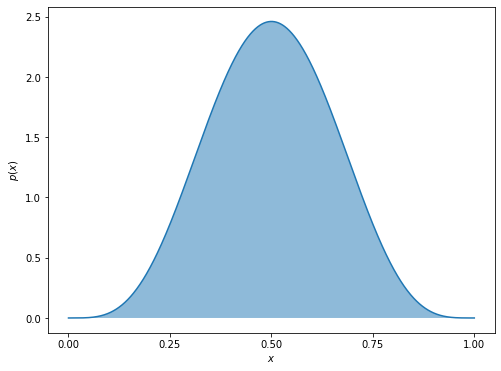

In [3]:
alpha = beta = 5
prior = stats.beta(alpha, beta)
x = np.linspace(0, 1, 1000)
y = prior.pdf(x)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(x, y)
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_xlabel('$ x $')
ax.set_ylabel('$ p(x) $')
ax.fill_between(x, np.zeros_like(x), y, alpha=0.5);

The above plot visualizes our beliefs about the fairness of the coin before we've flipped it. Its characteristics and shape are determined by the pre-existing knowledge we have about the problem before we've gathered any data. That is, the plot visualizes our prior distribution.

#### The likelihood function
The distribution over a sequence of coin flips also has a natural characterization in the form of the **binomial distribution**. For $ n $ flips, with probability of heads $ x $ on each flip, the probability mass function corresponding to $ k $ heads is 
$$ p_{n, x}(k) = \begin{pmatrix} n \\ k \end{pmatrix} x^{k} (1 - x)^{n - k}. \tag{1} $$ 
That is, $ k $ flips must result in heads, the other $ n - k $ flips must result in tails, and the ordering doesn't matter. This is the probability mass function for a binomial distribution over the number of heads given a number of flips $ n $ and a probability of success $ x $. However, fixing some observed sequence of coin flips containing some proportion of heads, it is also the likelihood function for the unknown probability of heads $ x $. That is, 
$$ L(x) = \begin{pmatrix} n \\ k \end{pmatrix} x^{k} (1 - x)^{n - k} \tag{2} $$
is the likelihood of the unknown parameter $ x $, given a sequence of $ n $ flips with $ k $ heads. **This is the same expression as above, interpreted differently**. (1) is a probability mass function over the number of heads in a sequence of $ n $ coin flips with probability of heads $ x $, while (2) is the likelihood function (in this case a polynomial) for the unknown parameter $ x $, given that we've observed a particular sequence of flips. Let's plot the likelihood function for different values of the number of heads $ k $, assuming the number of total flips is 10.

In [4]:
def binomial_likelihood(x, n, k):
    return special.comb(n, k) * x**k * (1 - x)**(n - k)

def plot_likelihood(k=5):
    x = np.linspace(0, 1, 1000)
    n = 10
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    y = binomial_likelihood(x, n, k)
    ax.plot(x, y, color='C2')
    ax.set_xlabel('$ x $')
    ax.set_ylabel('$ L(x) $')
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
    ax.set_ylim([0, 0.5])

interact(plot_likelihood, k=(1, 9, 1));

interactive(children=(IntSlider(value=5, description='k', max=9, min=1), Output()), _dom_classes=('widget-inte…

For 5 different observed data sets (the cases where we've observed 1, 3, 5, 7, and 9 heads in 10 coin flips), we've plotted the likelihood as a function of $ x $. **Look at where the likelihood function is peaked for each data set**: for data with low numbers of heads, it's peaked near $ 0 $, while for data with high numbers of heads, it's peaked near $ 1 $. Taking the maximum of the likelihood for each of these cases is the (big surprise) maximum likelihood estimate for the probability of heads $ x $, and corresponds to the result you would get if you went along with the original idea of keeping a running tally of the number of heads as you flipped.

However, we're Bayesians, and that just isn't good enough. Our posterior is given by multiplying the likelihood by the prior, and renormalizing the result. You should be beginning to see what the result of this multiplication will look like, but lets plot the unnormalized posterior for each of the data sets above to make it clear.  

In [5]:
def plot_unnormalized_posterior(k=5):
    x = np.linspace(0, 1, 1000)
    
    alpha = beta = 5
    prior = stats.beta(alpha, beta)
    
    n = 10
    x = np.linspace(0, 1, 1000)
    likelihood = binomial_likelihood(x, n, k)
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(x, prior.pdf(x), label='Prior')
    ax.fill_between(x, np.zeros_like(x), prior.pdf(x), alpha=0.5)
    
    ax.plot(x, likelihood, color='C2', label='Likelihood')
    
    ax.plot(x, likelihood * prior.pdf(x), color='C1', label='Unnormalized posterior')
    ax.fill_between(x, np.zeros_like(x), likelihood * prior.pdf(x), alpha=0.5)
    
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
    ax.legend()

interact(plot_unnormalized_posterior, k=(1, 9, 1));

interactive(children=(IntSlider(value=5, description='k', max=9, min=1), Output()), _dom_classes=('widget-inte…

In our toy dataset of 10 coin flips, the number of heads $ k $ we observed will change our posterior beliefs about the coin's fairness. This is exactly what's shown above: as we observe different numbers of heads, our unnormalized posterior concentrates on different values of the probability of heads $ x $. 

Now comes the special bit: it turns out the beta prior is conjugate to the binomial likelihood, and our unnormalized posterior is proportional to another beta distribution! This is easy to see, since our prior is a polynomial in $ x $, and our likelihood is a polynomial in $ x $, so our posterior is a polynomial in $ x $ as well. More concretely, the posterior is 
\begin{align}
p(x \vert n, k) &\propto L(x) p(x) \\
&\propto x^{k} (1 - x)^{n - k} x^{\alpha - 1} (1 - x)^{\beta - 1} \\
&= x^{(\alpha + k) - 1} (1 - x)^{(\beta + n - k) - 1}.
\end{align}
This expression uniquely characterises a beta distribution with parameters $ \alpha^{\prime} = \alpha + k $ and $ \beta^{\prime} = \beta + n - k $. We also know the normalizing constant: it's $ B(\alpha + k, \beta + n - k) $ necessarily. In this way, the parameters of the posterior beta distribution can be interpreted as 'counts' of heads and tails, respectively, and computing the posterior just requires addition. 

Thanks to conjugacy, we now have the exact posterior, so let's plot it, and play with some slightly bigger datasets as well (careful to ensure $ n $ is always bigger than $ k $ in the demo, since we can't have more heads than flips). Notice how as the size of the dataset increases, our posterior becomes increasingly peaked i.e. we become more certain about our beliefs the more data we see.

In [5]:
def plot_exact_posterior(n=10, k=5):
    x = np.linspace(0, 1, 1000)
    
    alpha = beta = 5
    prior = stats.beta(alpha, beta)
    
    x = np.linspace(0, 1, 1000)
    likelihood = binomial_likelihood(x, n, k)
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(x, prior.pdf(x), label='Prior')
    ax.fill_between(x, np.zeros_like(x), prior.pdf(x), alpha=0.5)
    
    ax.plot(x, likelihood, color='C2', label='Likelihood')
    
    alpha_prime = alpha + k
    beta_prime = beta + n - k
    posterior = stats.beta(alpha_prime, beta_prime)
    ax.plot(x, posterior.pdf(x), color='C1', label='Posterior')
    ax.fill_between(x, np.zeros_like(x), posterior.pdf(x), alpha=0.5)
    
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
    ax.legend()

interact(plot_exact_posterior, n=(10, 30, 5), k=(1, 29, 1));

interactive(children=(IntSlider(value=10, description='n', max=30, min=10, step=5), IntSlider(value=5, descrip…

Our Bayesian stranger is delighted with us; we've not just characterized our beliefs about the coin's fairness having seen data, but we've given him a closed form posterior defined by just two scalar values, $ \alpha^{\prime} $ and $ \beta^{\prime} $. With just these two numbers, we've fully quantified our beliefs about the coin's fairness, and no matter how much data we ever gather, all we need are two numbers to communicate those beliefs i.e. $ n $ and $ k $ are **sufficient statistics** of the data.